In [14]:
from __future__ import annotations
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from jax.tree_util import register_dataclass
import jaxtyping
import optax
import matplotlib.pyplot as plt
import numpy as np

import hodel
import hodel.dismech as dismech


def from_geo(geo):
    conn = dismech.Connectivity.from_geo(geo)
    state = dismech.StaticState.from_geo(geo, conn)

    node_dofs = dismech.map_node_to_dof(
        jnp.asarray(geo.bend_twist_springs[:, [0, 2, 4]], dtype=jnp.int32)
    )

    l0 = jnp.linalg.norm(state.q[node_dofs[:, 1]] - state.q[node_dofs[:, 0]], axis=1)
    l1 = jnp.linalg.norm(state.q[node_dofs[:, 2]] - state.q[node_dofs[:, 1]], axis=1)
    l_k = jnp.stack([l0, l1], axis=1)

    return (
        conn,
        state,
        jax.vmap(dismech.ParametrizedDERTriplet.init, (0, 0, 0, 0, 0, None))(
            node_dofs,
            conn.triplet_edge_dofs,
            conn.triplet_signs,
            l_k,
            jnp.arange(node_dofs.shape[0])[..., None],
            state,
        ),
    )


EA = jnp.array([40.0, 40.0])
EI = jnp.array([3.33333333e-03, 3.33333333e-03])
GJ = jnp.array([2.22222222e-03])
Theta_star = jnp.concat([EA, EI, GJ])
geo = dismech.Geometry.from_txt("rod.txt")
conn, state, triplets = from_geo(geo)

idx_f = jnp.array(
    [  # 0, 1, 2,
        3,
        4,
        5,
        6,
        7,
        8,
        # 9, 10, 11,
        # 12,
        13,
        # 14,
    ]
)
idx_b = jnp.setdiff1d(jnp.arange(15), idx_f)
mass = jnp.concat(
    [
        jnp.ones(geo.nodes.shape[0] * 3) * 1.25663706e-03,
        jnp.ones(geo.edges.shape[0]) * 5.02654825e-07,
    ]
)


@register_dataclass
@dataclass(frozen=True)
class TripletAux:
    """parametrized external force."""

    top: dismech.Connectivity
    idx_f: jax.Array
    idx_b: jax.Array


def get_W(lambda_: jax.Array, aux: TripletAux):
    # jax.debug.print("{}", lambda_ * jnp.array([0, 0, 1, 0, 0, 1, 0]) * -9.81 * 1e-2)
    return lambda_ * jnp.array([0, 0, 1.0, 0, 0, 1, 0]) * -9.81 * 1e-2


def fixed_0(lambda_: jax.Array, aux: TripletAux) -> jax.Array:
    return jnp.array([0, 0, 0, 0.03, 0, 0, 0, 0]) + lambda_ * jnp.array(
        [0, 0.01, 0, 0, 0, 0, 0, 0]
    )


def update_state(
    xf: jax.Array, xb: jax.Array, aux: TripletAux, carry: dismech.StaticState
) -> dismech.StaticState:
    q = jnp.empty((aux.idx_f.shape[0] + aux.idx_b.shape[0]), xf.dtype)
    q = q.at[aux.idx_f].set(xf).at[aux.idx_b].set(xb)
    return carry.update(q, aux.top)


def get_batch_energy(xf, xb, Theta, aux, carry):
    q = jnp.empty((aux.idx_f.shape[0] + aux.idx_b.shape[0]), xf.dtype)
    q = q.at[aux.idx_f].set(xf).at[aux.idx_b].set(xb)
    state = carry.update(q, aux.top)
    return jnp.sum(jax.vmap(lambda t: t.get_energy(state, Theta))(triplets))


xf0 = state.q[idx_f]
aux = TripletAux(conn, idx_f, idx_b)
sim = hodel.HODEL(
    get_batch_energy, get_W_fn=get_W, get_xb_fn=fixed_0, carry_fn=update_state
)

True Theta: [4.0000000e+01 4.0000000e+01 3.3333334e-03 3.3333334e-03 2.2222223e-03]
Theta0: [9.477194  9.786013  3.3295918 4.691998  5.7031884]
Final Theta: [30.156332  30.15637    3.3261173  4.691998   5.7031884]


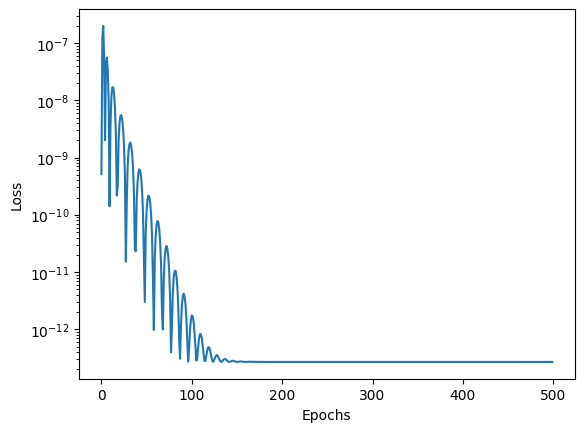

In [15]:
lambdas = jnp.linspace(0, 1.0, 10)
xf_star = sim.sim(lambdas, xf0, Theta_star, aux, state)
key = jax.random.PRNGKey(0)
Theta0 = jax.random.uniform(key, [5], minval=1e-2, maxval=1e1)
lr = 1e1
nepochs = 500

final_Theta, L = sim.learn(
    lambdas,
    xf0,
    xf_star,
    Theta0,
    aux,
    state,
    optim=optax.adam(lr),
    nepochs=nepochs,
)

print("True Theta:", Theta_star)
print("Theta0:", Theta0)
print("Final Theta:", final_Theta)

plt.plot(L)
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()